## Assignment 1 - Exploring CNNs on CIFAR-10 dataset
### Team members:
#### - Kaleb Roncatti de Souza
#### - Nelson Gomes Brasil Junior

In [28]:
!pip3 install visualkeras

In [29]:
import tensorflow as tf
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
import visualkeras
import os
import random as rn
from keras import callbacks
from keras.activations import leaky_relu, relu, sigmoid


rs = 321
# Setting up random state to specific seed so we can have reproductibility
os.environ['PYTHONHASHSEED']=str(rs)
np.random.seed(rs)
tf.random.set_seed(rs)
rn.seed(rs)

In [30]:
# Loading train and test set
(x_train , y_train), (x_test , y_test) = tf.keras.datasets.cifar10.load_data()

In [31]:
# Function to shuffle
def shuffle_tensor(x: np.ndarray , y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
    shuffled_indices = tf.random.shuffle(indices, seed=rs)
    return tf.gather(x, shuffled_indices), tf.gather(y, shuffled_indices)

# Function to split dataset
def split_dataset(x: np.ndarray, y: np.ndarray, percentage: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    if len(x) != len(y):
        raise ValueError("array x and y must have the same length")
    
    # Shuffling dataset
    x, y = shuffle_tensor(x=x, y=y)

    # Finding the splits after shuffling
    total_elements = len(y)
    data = int(percentage * total_elements)
    return x[0:data], y[0:data], x[data:], y[data:]


In [32]:
#################################################################
## Atividade 1. Splitting training and validation
x_train, y_train, x_val, y_val = split_dataset(x=x_train, y=y_train, percentage = 0.8)
print(f"We splitted the training dataset using the following percentage: {len(x_train)/(len(x_train) + len(x_val))}")
print(f"Training dataset has the following shape: x ==> {x_train.shape}, y ==> {y_train.shape}")
print(f"Validation dataset has the following shape: x ==> {x_val.shape}, y ==> {y_val.shape}")

We splitted the training dataset using the following percentage: 0.8
Training dataset has the following shape: x ==> (40000, 32, 32, 3), y ==> (40000, 1)
Validation dataset has the following shape: x ==> (10000, 32, 32, 3), y ==> (10000, 1)


In [33]:
# Normalize data between [0, 1]
x_train = tf.cast(x_train, tf.float32) / 255.0
x_val = tf.cast(x_val, tf.float32) / 255.0
x_test = tf.cast(x_test, tf.float32) / 255.0


# One hot encoding on labels
num_classes = len(np.unique(y_train))
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes)
print(x_train.shape, y_train_oh.shape)

(40000, 32, 32, 3) (40000, 10)


In [34]:
# Checking if we have a balanced dataset
# Para o conjunto de treino
unique, counts = np.unique(y_train, return_counts=True)
print("Train ---> ", dict(zip(unique, counts)))
unique, counts = np.unique(y_val, return_counts=True)
print("Validation ---> ", dict(zip(unique, counts)))

Train --->  {0: 4012, 1: 3998, 2: 4034, 3: 3993, 4: 4006, 5: 4007, 6: 4035, 7: 4006, 8: 3947, 9: 3962}
Validation --->  {0: 988, 1: 1002, 2: 966, 3: 1007, 4: 994, 5: 993, 6: 965, 7: 994, 8: 1053, 9: 1038}


We can consider that the dataset is more or less balanced. We could also adjust the weights based on their proportion, but for simplicity, let's keep going considering the dataset is completely balanced.

In [35]:
print(x_train[0].shape)


(32, 32, 3)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 7200)              0         
                                                                 
 dense_8 (Dense)             (None, 10)                72010     
                                                                 
Total params: 72,906
Trainable params: 72,906
Non-trainable params: 0
_________________________________________________________________


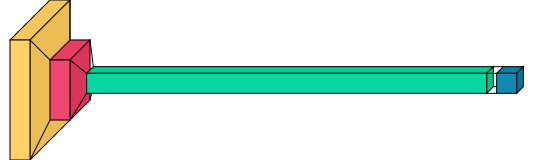

In [36]:
#################################################################
## Atividade 2. Creating a very simple convolutional neural net

def create_baseline_model(input_shape=x_train[0].shape, activation = relu) -> tf.keras.Sequential():
    model = tf.keras.Sequential()

    # Convolutional layer with 32 filters, 3x3 each
    model.add(
        layers.Conv2D(
            filters=32, 
            kernel_size=(3, 3), 
            padding='valid', 
            activation=activation, 
            input_shape=x_train[0].shape))
    #Max pooling of size 3x3
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # Flattening
    model.add(layers.Flatten())
    # Output layer
    model.add(layers.Dense(10))

    return model

model = create_baseline_model()
model.summary()
# Taking a look at the neural net
visualkeras.layered_view(model)


In [37]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [38]:
# Training the baseline model and saving it
device = '/gpu:0' # or '/cpu:0' if you don't have GPU
with tf.device(device):
    model.fit(
        x_train, y_train_oh, 
        epochs=50, 
        batch_size=64,
        validation_data=(x_val, y_val_oh),
        verbose=1,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                'weights_baseline.h5',
                save_best_only=True,
                verbose=1),
        ]
        )

Epoch 1/50
623/625 [============================>.] - ETA: 0s - loss: 1.5820 - accuracy: 0.4438
Epoch 1: val_loss improved from inf to 1.37244, saving model to weights_baseline.h5
625/625 [==============================] - 12s 18ms/step - loss: 1.5812 - accuracy: 0.4441 - val_loss: 1.3724 - val_accuracy: 0.5214
Epoch 2/50
621/625 [============================>.] - ETA: 0s - loss: 1.2848 - accuracy: 0.5534
Epoch 2: val_loss improved from 1.37244 to 1.28337, saving model to weights_baseline.h5
625/625 [==============================] - 11s 18ms/step - loss: 1.2842 - accuracy: 0.5536 - val_loss: 1.2834 - val_accuracy: 0.5455
Epoch 3/50
621/625 [============================>.] - ETA: 0s - loss: 1.1984 - accuracy: 0.5846
Epoch 3: val_loss improved from 1.28337 to 1.23583, saving model to weights_baseline.h5
625/625 [==============================] - 13s 20ms/step - loss: 1.1986 - accuracy: 0.5843 - val_loss: 1.2358 - val_accuracy: 0.5678
Epoch 4/50
625/625 [==============================] -

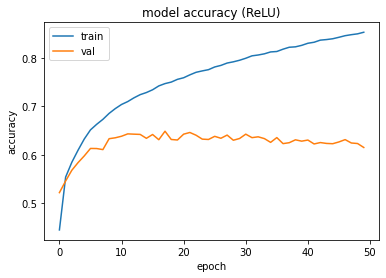

In [39]:
# Observing the model accuracy through the epochs
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy (ReLU)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [40]:
#################################################################
## Atividade 3. Exploring OTHER two activation types, since we already played with ReLU

model_sigmoid = create_baseline_model(activation=sigmoid)
model_sigmoid.summary()
# Compiling the model
model_sigmoid.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_leaky_relu = create_baseline_model(activation=leaky_relu)
model_leaky_relu.summary()
# Compiling the model
model_leaky_relu.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 7200)              0         
                                                                 
 dense_9 (Dense)             (None, 10)                72010     
                                                                 
Total params: 72,906
Trainable params: 72,906
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_12"
_________________________________________________________________
 Layer (type)             

In [41]:
# Training the baseline model and saving it with OTHER ACTIVATIONS
# Sigmoid
with tf.device(device):
    model_sigmoid.fit(
        x_train, y_train_oh, 
        epochs=50, 
        batch_size=64,
        validation_data=(x_val, y_val_oh),
        verbose=1,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                'weights_baseline_sigmoid.h5',
                save_best_only=True,
                verbose=1),
        ]
        )
        
# Leaky ReLU
with tf.device(device):
    model_leaky_relu.fit(
        x_train, y_train_oh, 
        epochs=50, 
        batch_size=64,
        validation_data=(x_val, y_val_oh),
        verbose=1,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                'weights_baseline_leaky_relu.h5',
                save_best_only=True,
                verbose=1),
        ]
        )

Epoch 1/50
624/625 [============================>.] - ETA: 0s - loss: 2.1340 - accuracy: 0.2485
Epoch 1: val_loss improved from inf to 1.96852, saving model to weights_baseline_sigmoid.h5
625/625 [==============================] - 18s 27ms/step - loss: 2.1338 - accuracy: 0.2485 - val_loss: 1.9685 - val_accuracy: 0.2988
Epoch 2/50
625/625 [==============================] - ETA: 0s - loss: 1.8877 - accuracy: 0.3377
Epoch 2: val_loss improved from 1.96852 to 1.84715, saving model to weights_baseline_sigmoid.h5
625/625 [==============================] - 10s 17ms/step - loss: 1.8877 - accuracy: 0.3377 - val_loss: 1.8472 - val_accuracy: 0.3388
Epoch 3/50
622/625 [============================>.] - ETA: 0s - loss: 1.8080 - accuracy: 0.3676
Epoch 3: val_loss improved from 1.84715 to 1.81333, saving model to weights_baseline_sigmoid.h5
625/625 [==============================] - 12s 20ms/step - loss: 1.8077 - accuracy: 0.3677 - val_loss: 1.8133 - val_accuracy: 0.3504
Epoch 4/50
624/625 [=========

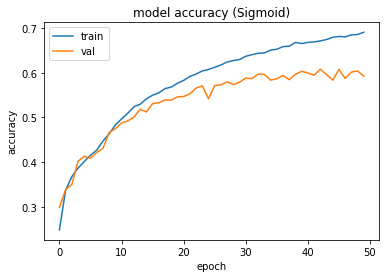

In [42]:
# Observing the model accuracy through the epochs for SIGMOID
plt.plot(model_sigmoid.history.history['accuracy'])
plt.plot(model_sigmoid.history.history['val_accuracy'])
plt.title('model accuracy (Sigmoid)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

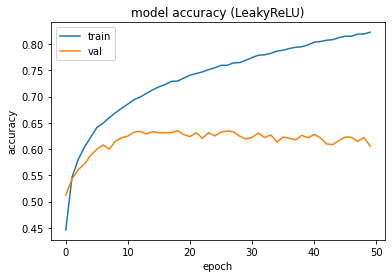

In [43]:
# Observing the model accuracy through the epochs for LeakyReLU
plt.plot(model_leaky_relu.history.history['accuracy'])
plt.plot(model_leaky_relu.history.history['val_accuracy'])
plt.title('model accuracy (LeakyReLU)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_23 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 6272)              0         
                                                                 
 dense_11 (Dense)            (None, 10)                62730     
                                                                 
Total params: 72,874
Trainable params: 72,874
Non-trainable params: 0
_________________________________________________

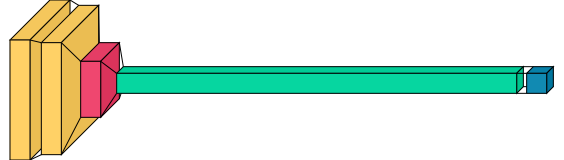

In [44]:
model_complex = tf.keras.Sequential()

model_complex.add(
    layers.Conv2D(
        filters=32, 
        kernel_size=(3, 3), 
        padding='valid', 
        activation=leaky_relu, 
        input_shape=x_train[0].shape))
model_complex.add(
    layers.Conv2D(
        filters=32, 
        kernel_size=(3, 3), 
        padding='valid', 
        activation=leaky_relu))

model_complex.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Flattening
model_complex.add(layers.Flatten())
# Output layer
model_complex.add(layers.Dense(10))

model_complex.summary()
# Compiling the model
model_complex.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Taking a look at the neural net
visualkeras.layered_view(model_complex)

In [45]:
with tf.device(device):
    model_complex.fit(
        x_train, y_train_oh, 
        epochs=30, 
        batch_size=64,
        validation_data=(x_val, y_val_oh),
        verbose=1,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                'weights_complex.h5',
                save_best_only=True,
                verbose=1),
        ]
        )

Epoch 1/50
624/625 [============================>.] - ETA: 0s - loss: 1.4882 - accuracy: 0.4733
Epoch 1: val_loss improved from inf to 1.26506, saving model to weights_complex.h5
625/625 [==============================] - 27s 43ms/step - loss: 1.4877 - accuracy: 0.4735 - val_loss: 1.2651 - val_accuracy: 0.5551
Epoch 2/50
625/625 [==============================] - ETA: 0s - loss: 1.1469 - accuracy: 0.6020
Epoch 2: val_loss improved from 1.26506 to 1.11505, saving model to weights_complex.h5
625/625 [==============================] - 26s 41ms/step - loss: 1.1469 - accuracy: 0.6020 - val_loss: 1.1151 - val_accuracy: 0.6114
Epoch 3/50
624/625 [============================>.] - ETA: 0s - loss: 1.0276 - accuracy: 0.6479
Epoch 3: val_loss improved from 1.11505 to 1.05584, saving model to weights_complex.h5
625/625 [==============================] - 26s 42ms/step - loss: 1.0275 - accuracy: 0.6479 - val_loss: 1.0558 - val_accuracy: 0.6319
Epoch 4/50
625/625 [==============================] - ET

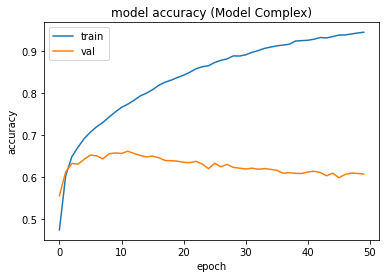

In [46]:
# Observing the model accuracy through the epochs for model complex 0
plt.plot(model_complex.history.history['accuracy'])
plt.plot(model_complex.history.history['val_accuracy'])
plt.title('model accuracy (Model Complex)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 12, 12, 16)        4624      
                                                                 
 conv2d_27 (Conv2D)          (None, 10, 10, 16)        2320      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                

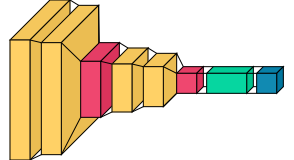

In [47]:
#################################################################
## Atividade 4. Exploring more complex CNNs to improve our model

model_complex_1 = tf.keras.Sequential()

model_complex_1.add(
    layers.Conv2D(
        filters=32, 
        kernel_size=(3, 3), 
        padding='valid', 
        activation=leaky_relu, 
        input_shape=x_train[0].shape))
model_complex_1.add(
    layers.Conv2D(
        filters=32, 
        kernel_size=(3, 3), 
        padding='valid', 
        activation=leaky_relu))

model_complex_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_complex_1.add(
    layers.Conv2D(
        filters=16, 
        kernel_size=(3, 3), 
        padding='valid', 
        activation=leaky_relu, 
        input_shape=x_train[0].shape))
model_complex_1.add(
    layers.Conv2D(
        filters=16, 
        kernel_size=(3, 3), 
        padding='valid', 
        activation=leaky_relu))

model_complex_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flattening
model_complex_1.add(layers.Flatten())
# Output layer
model_complex_1.add(layers.Dense(10))

model_complex_1.summary()
# Compiling the model
model_complex_1.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Taking a look at the neural net
visualkeras.layered_view(model_complex_1)

In [48]:
with tf.device(device):
    model_complex_1.fit(
        x_train, y_train_oh, 
        epochs=30, 
        batch_size=64,
        validation_data=(x_val, y_val_oh),
        verbose=1,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                'weights_complex_1.h5',
                save_best_only=True,
                verbose=1),
        ]
        )

Epoch 1/30
625/625 [==============================] - ETA: 0s - loss: 1.6659 - accuracy: 0.3889
Epoch 1: val_loss improved from inf to 1.39993, saving model to weights_complex_1.h5
625/625 [==============================] - 25s 39ms/step - loss: 1.6659 - accuracy: 0.3889 - val_loss: 1.3999 - val_accuracy: 0.4948
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 1.3377 - accuracy: 0.5236
Epoch 2: val_loss improved from 1.39993 to 1.27846, saving model to weights_complex_1.h5
625/625 [==============================] - 23s 37ms/step - loss: 1.3377 - accuracy: 0.5236 - val_loss: 1.2785 - val_accuracy: 0.5376
Epoch 3/30
624/625 [============================>.] - ETA: 0s - loss: 1.2090 - accuracy: 0.5716
Epoch 3: val_loss improved from 1.27846 to 1.15459, saving model to weights_complex_1.h5
625/625 [==============================] - 22s 36ms/step - loss: 1.2088 - accuracy: 0.5717 - val_loss: 1.1546 - val_accuracy: 0.5930
Epoch 4/30
625/625 [==============================

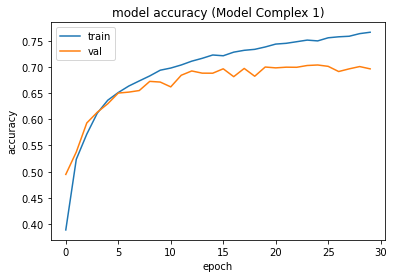

In [49]:
# Observing the model accuracy through the epochs for model complex 1
plt.plot(model_complex_1.history.history['accuracy'])
plt.plot(model_complex_1.history.history['val_accuracy'])
plt.title('model accuracy (Model Complex 1)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()